# Setup

---

The idea for the following project came from a [Medium post](https://medium.com/@dmytrosazonov/how-to-predict-stock-market-using-google-tensorflow-and-lstm-neural-network-81ccc41a22a8). We improve the Medium's code adding new models and new analysis. To do that, the group used as tools the [ChatGPT](https://chat.openai.com/) optimizations and the [Aurélien Geron's public notebooks](https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb)


In [ ]:
import datetime as dt
import time as tm

# AI
import keras

# Graphics library
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Data preparation
from yahoo_fin import stock_info as yf

from utils import (
    last_time_step_mse,
    plot_learning_curves,
    plot_multiple_forecasts,
    plot_series,
)

## Data

--- 

#### Load Data From Yahoo API

In [ ]:
tf.random.set_seed(42)

ANALYZED_YEARS = 5
STOCK = "GOOGL"
INTERVAL = "1d"
N_STEPS = 22  # working days of a month
EPOCHS = 50

In [ ]:
init_df = yf.get_data(
    STOCK,
    start_date=(dt.date.today() - dt.timedelta(days=365 * ANALYZED_YEARS)).strftime(
        "%Y-%m-%d"
    ),
    end_date=tm.strftime("%Y-%m-%d"),
    interval=INTERVAL,
)
init_df.to_csv(f"./data/raw/{STOCK}_{ANALYZED_YEARS}Y_{INTERVAL}.csv")
init_df.head()

In [ ]:
# remove unused columns
init_df.drop(
    ["open", "high", "low", "adjclose", "ticker", "volume"], axis=1, inplace=True
)
init_df["date"] = init_df.index
init_df.reset_index(drop=True, inplace=True)

# Scale
scaler = MinMaxScaler()
init_df["close_norm"] = scaler.fit_transform(
    np.expand_dims(init_df["close"].values, axis=1)
)
init_df.to_csv(f"./data/processed/{STOCK}_{ANALYZED_YEARS}Y_{INTERVAL}.csv")

# Save scaled array
np.save(
    f"./data/processed/{STOCK}_{ANALYZED_YEARS}Y_{INTERVAL}_norm", init_df["close_norm"]
)

init_df.head()


#### Visualization 

In [ ]:
plt.style.use(style="ggplot")
plt.figure(figsize=(16, 10))
plt.plot(init_df["date"], init_df["close"])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f"Actual price for {STOCK}"])
plt.show()

#### Data split

In [ ]:
data = np.load(f"./data/processed/{STOCK}_{ANALYZED_YEARS}Y_{INTERVAL}_norm.npy")

data = np.reshape(data[data.size % N_STEPS :], (data.size // N_STEPS, N_STEPS, 1))

X_train, y_train = (
    data[: int(data.shape[0] * 0.8), : N_STEPS - 1],
    data[: int(data.shape[0] * 0.8), -1],
)
X_test, y_test = (
    data[int(data.shape[0] * 0.8):, : N_STEPS - 1],
    data[int(data.shape[0] * 0.8):, -1],
)

## Models

---

#### Naive Forecasting

In [ ]:
y_pred = X_test[:, -1]
np.mean(keras.losses.mean_squared_error(y_pred, y_test))

#### Linear Regression

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential(
    [keras.layers.Flatten(input_shape=[N_STEPS - 1, 1]), keras.layers.Dense(1)]
)

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test))
model.save(f"./models/LR_{STOCK}_{ANALYZED_YEARS}Y_{INTERVAL}-{N_STEPS}timeSteps")

1/1 [==============================] - 0s 15ms/step - loss: 0.0028


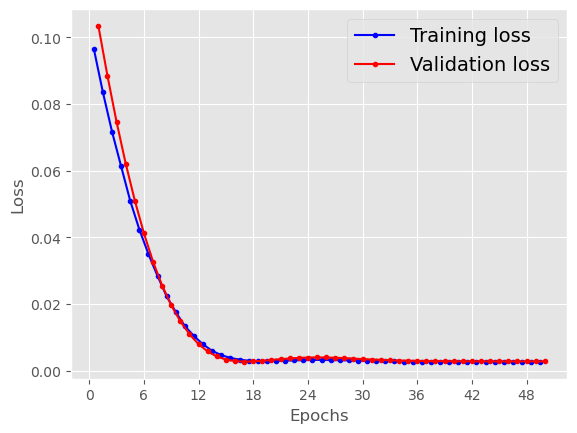

In [9]:
model.evaluate(X_test, y_test)
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

1/1 [==============================] - 0s 41ms/step


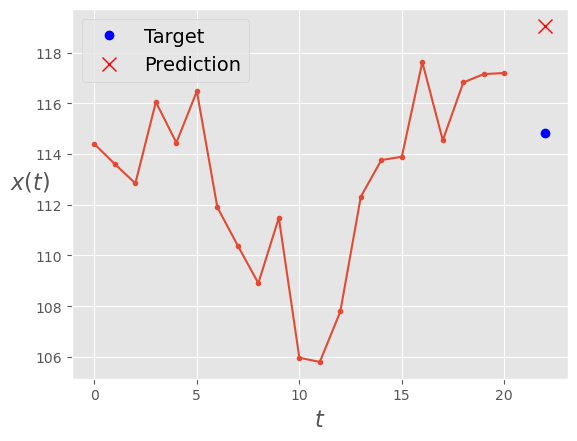

In [10]:
y_pred = model.predict(X_test)
plot_series(scaler.inverse_transform([X_test[0, :,0]])[0], scaler.inverse_transform(np.array([[y_test[0,0]]])), scaler.inverse_transform(np.array([[y_pred[0,0]]])), n_steps=N_STEPS)
plt.show()